# 2016 Election Analysis
## L2 Regularization
### Ben Albrecht
#### I. Introduction
This Jupyter Notebook utilizes different supervised linear methods for identifying critical state-level features during the 2016 US presidential election. 

The 2016 US presidential election was a critical moment in US politics. President Donald Trump defeated Secretary of State Hillary Clinton, transferring power from the Democrats to the Republicans. Trump's ascent was notable because it ultimately redefined the Republican party. Moving away from establishment "country-club" style Republicanism and towards a populist vision rooted in sections of the Republican coalition such as the Tea Party and the Evangelical Christian movement.

Educational polarization in Western democracies has been part of this story. Beginning in the 1950s - 60s, center-left parties began losing working-class voters' support. In much of sociology and political science, the working class is identified as those who do not have a college education. This corresponds with people in blue-collar professions, who typically do not work in an office. 

In the US, many political scientists identify this as beginning in the 1960s. During this period, President Johnson made significant strides in anti-racist legislation. As the Democratic Party began to be associated with civil rights and progressive social issues, many white working-class voters moved to the right, particularly in the South. 

This trend accelerated under Trump, when white working-class voters in the Midwest became vital to the Republican coalition that delivered him the White House. Explanations for this education realignment vary from Democratic support for progressive social issues to support for free trade agreements like NAFTA. 

In this analysis, I gathered state-level features from the US Census American Community Survey (ACS), the US Federal Election Commission (FEC), and polling from the election forecaster 538. Using this data, we will utilize various supervised linear methods to see if we can identify the effects of education polarization on the 2016 presidential election.

#### II. Exploratory Data Analysis and Description of Data
I created this dataset using state-level features from the ACS, FEC, and 538. Let's open the file so we can discuss each of the features.

In [191]:
# Import libraries.
import pandas as pd
import numpy as np

# Open data.
data = pd.read_csv('data.csv')
data.head(5)

,state_po,D12,D16,bach2016,bach_white2016,538_2016_avg,Manuf_Constr
0,AL,0.387838,0.356259,0.247,0.273,0.334540,0.208
1,AK,0.426847,0.416143,0.296,0.367,0.353876,0.117
2,AZ,0.453866,0.481100,0.289,0.353,0.423319,0.152
3,AR,0.378456,0.357149,0.224,0.240,0.344622,0.204
4,CA,0.618728,0.661282,0.329,0.431,0.556942,0.154


For each state we have a numer of features:
| Variable | Description |
| ----------- | ----------- |
| state_po | Abbreviations for each US state |
| D12 | Democratic share of the two-party vote in the 2012 presidential election |
| D16 | Democratic share of the two-party vote in the 2016 presidential election |
| bach2016 | Proportion of adults with at least a 4 year college education |
| bach_white2016 | Proportion of white adults with at least a 4 year college education |
| 538_2016_avg | Average of polls from the last 3 weeks of the 2016 presidential election |
| Manuf_Constr | Proportion of adults working in manufacturing or construction  |

In supervised machine learning we have a target and a set of predictors. In general, we are trying to understand the linear model:
$$
y = \beta X
$$
where $\beta$ identified the effect of X on y. Here, our target is the Democratic share of the two-party vote in 2016. Our predictors are D12, bach2016, bach_white2016, 538_2016_avg, and Manuf_Constr.

Before we continue, it's important to discuss why the vote shares are of the two-party vote. The US has a two-party system, with the two major parties being the only real effective competitors. It's essential only to use the two-party vote share. If we used the total, we could bias our statistical analysis. Specifically, some elections have unordinary periods of 3rd party support, which obscure actual results. More importantly, because the US uses a first past the post system, winning means beating the other major party, not receiving a certain proportion of votes.

Let's conduct some exploratory data analysis.

c:\Users\benjo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


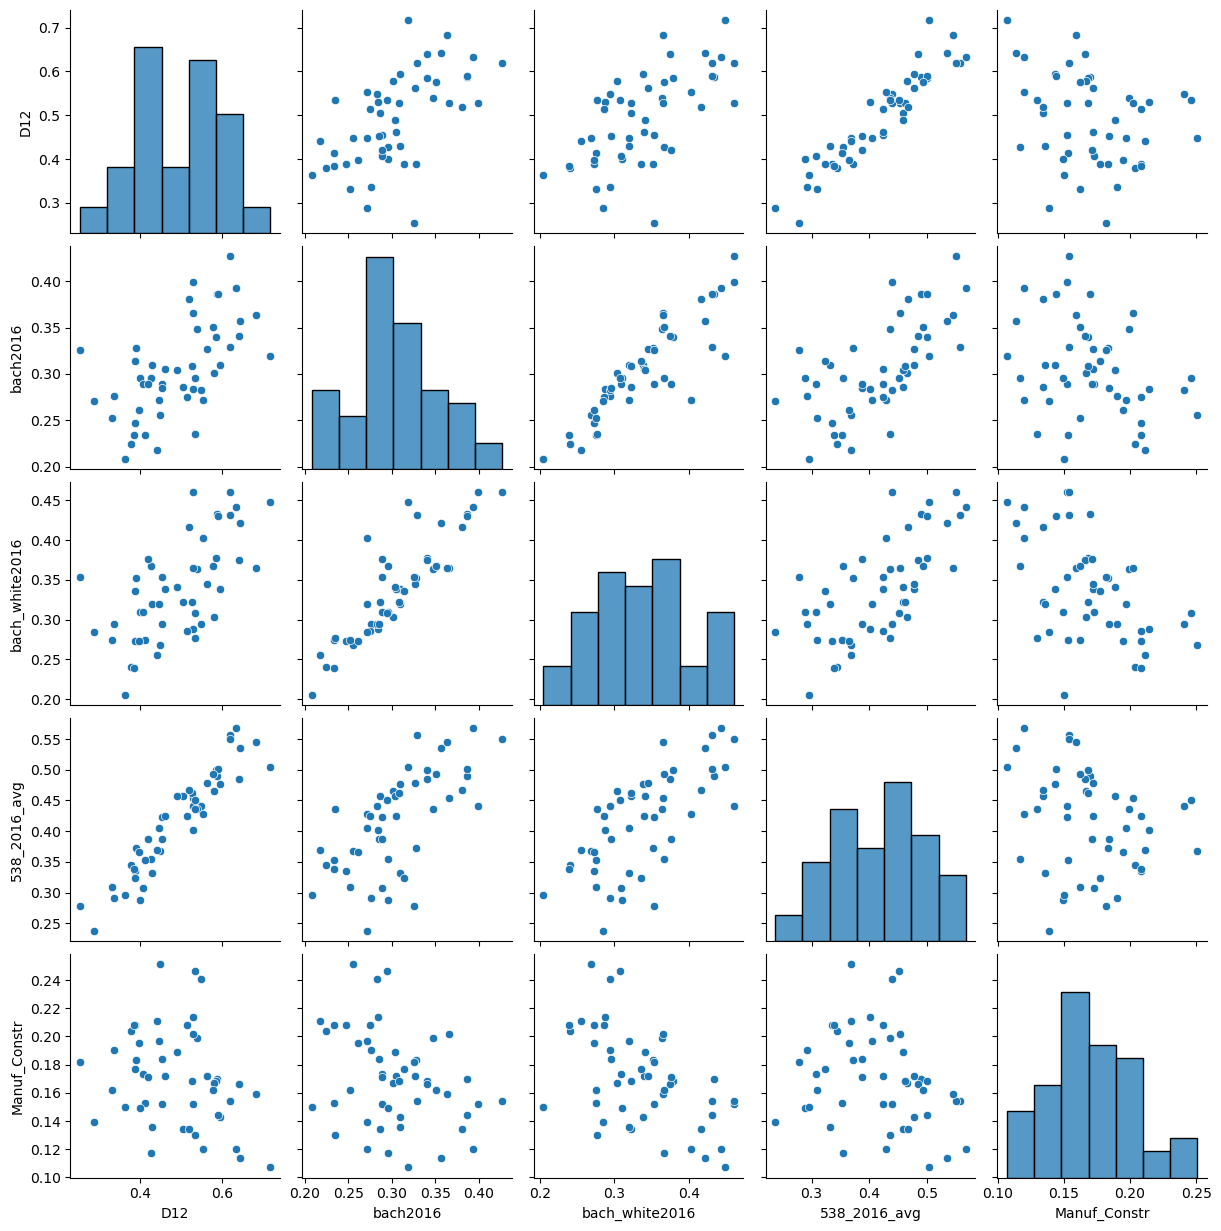

In [192]:
import seaborn as sns

# Visualize data with pairplot.
sns.pairplot(data[['D12', 'bach2016', 'bach_white2016', '538_2016_avg', 'Manuf_Constr']]);

At first glance, our dataset may have multicollinearity problems. This means that our predictors are correlated, which makes using OLS problematic. Specifically in OLS, our coefficient estimates should identify the change in our target variable $y$ when we have a unit change in a predictor $x$, holding all the other predictors constant. But if our predictors are correlated, then a change in one is associated with a change in another.

Let's ensure that the predictors are correlated with one another with a heatmap.

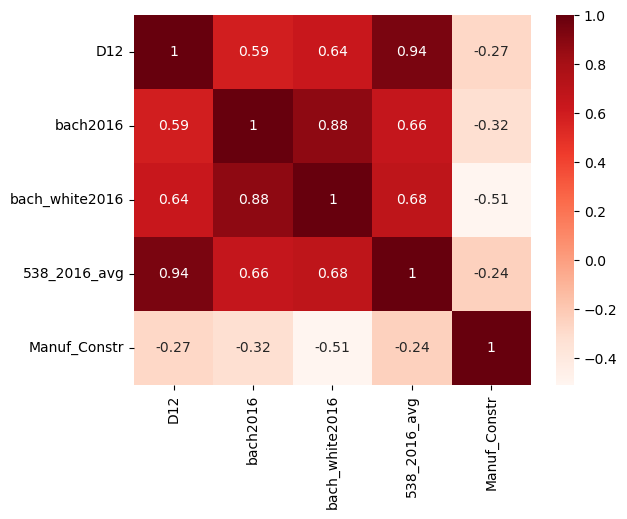

In [193]:
# Get correlations.
corr = data[['D12', 'bach2016', 'bach_white2016', '538_2016_avg', 'Manuf_Constr']].corr()

# Plot heatmap.
sns.heatmap(corr, annot=True, cmap='Reds');

Many of our predictors have this multicollinearity issue. This makes sense if we step back and consider the dataset. Of course, education levels are correlated with the Democratic vote share. Additionally, it's no surprise that the 538 voting average correlates well with the previous election. 

#### III. Regression Analysis
The ridge regression (L2 regularization) solves this multicollinearity problem. The key to ridge regression is to improve parameter estimation in exchange for additional bias. Ridge regression does this by shrinking the OLS estimators with a penalty term. Consider the ordinary least squares (OLS) estimators.
$$
\hat{\beta} = (X^T X)^{-1} X^T y
$$
The ridge regression estimates are very similar, however to shrink the estimates we introduce a penalty term $\lambda$.
$$
\hat{\beta}^{ridge} = (X^T X + \lambda I)^{-1} X^T y
$$
To begin, let's look at the results of OLS on our data.

In [194]:
# Remove state labels and get target.
states = data.pop('state_po')
y = data.pop('D16')

# OLS model.
from ordinary_ls import OLS

model_OLS = OLS(data, y)
model_OLS.fit()
model_OLS.summarize()

             Term  Coefficient  Std. Error      t  p val.
0       Intercept      -0.1025       0.029 -3.549   0.001
1             D12       0.3108       0.076  4.078   0.000
2        bach2016      -0.3054       0.121 -2.527   0.015
3  bach_white2016       0.5665       0.113  5.020   0.000
4    538_2016_avg       0.7564       0.105  7.185   0.000
5    Manuf_Constr       0.0425       0.100  0.423   0.674


Looking at our summary, we can see that every variable but Manuf_Constr is statistically significant. However, can we trust our estimates under multicollinearity? Likely not! However, assuming we could trust these estimates, we could say that a $1%$ in college education for white adults would correspond to a $.005665$ increase in the Democratic two-party vote share. This would imply that it is in the interest of Democrats to increase white educational attainment.

We'll now utilize the ridge regression to deal with our multicollinearity problems.

In [195]:
# Center target.
y_mean = y.mean()
y = y - y_mean

# Center predictors.
X_means = data.mean()
X = data - X_means

# Drop intercept from X.
X.drop('Intercept', axis=1, inplace=True)

# Ridge model.
from ridge import ridge_reg

model_ridge = ridge_reg(X, y)
model_ridge.fit()
res = model_ridge.result

The ridge regression model identifies the best $\lambda$ with K-fold cross-validation (in this case, 10-folds). We'll need to utilize the one standard error rule to identify the best model. The following code finds the best model and then determines the simplest model within one standard error of that model. This simple model will be the final model.

In [196]:
res

,edfs,cv_err,cv_std_err
0,0.0,0.011720,0.000633
1,1.0,0.001902,0.000098
2,2.0,0.000578,0.000063
3,3.0,0.000411,0.000059
4,4.0,0.000344,0.000057
5,5.0,0.000319,0.000057


In [197]:
# Find the best model.
best_mod_idx = res.cv_err.idxmin()
best_mask = res.index == best_mod_idx
res['best'] = np.where(best_mask, 1, 0)

# Find model within one standard deviation of the best model.
res['within_one'] = (res['cv_err'] + res['cv_std_err'])
res['within_'] = np.where(res.cv_err <= res.within_one[best_mod_idx], 1, 0)

optimal_model_idx = res['within_'].idxmax()
optimal_mask = res.index == optimal_model_idx

# Coordinates for plotting.
y_coord = res[best_mask].within_one
x_coord = res[optimal_mask].edfs

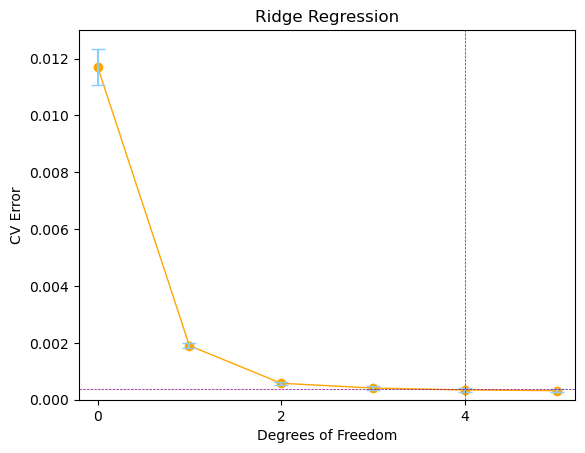

In [198]:
import matplotlib.pyplot as plt

# Graph of CV Errors to identify final model.
plt.plot(res['edfs'], res['cv_err'], 'o-', color='orange', lw=1)
plt.errorbar(res['edfs'], res['cv_err'], yerr=res['cv_std_err'], ecolor='lightskyblue', ls='None', capsize=5)

plt.xticks([0, 2, 4])
plt.ylim(0, 0.013)
plt.xlim(-.2, 5.2)

plt.plot([-.2, 5.2], [y_coord, y_coord], '--', color='purple', lw=0.5)
plt.plot([x_coord, x_coord],[0,0.013], '--', color='purple', lw=0.5)


plt.title("Ridge Regression")
plt.xlabel('Degrees of Freedom')
plt.ylabel('CV Error')

plt.show()

From 10-fold cross-validation, we can see that the final model will have four degrees of freedom. Before we examine the final model, let's examine the change in our predictor coefficients as the degrees of freedom / penalty $\lambda$ change.

In [199]:
# Examining the change in predictor coefficients with changing hyperparameter / penalty.
model_ridge2 = ridge_reg(X, y, inc=0.5, cross_valid=False)
model_ridge2.fit()
ridge_betas = model_ridge2.result

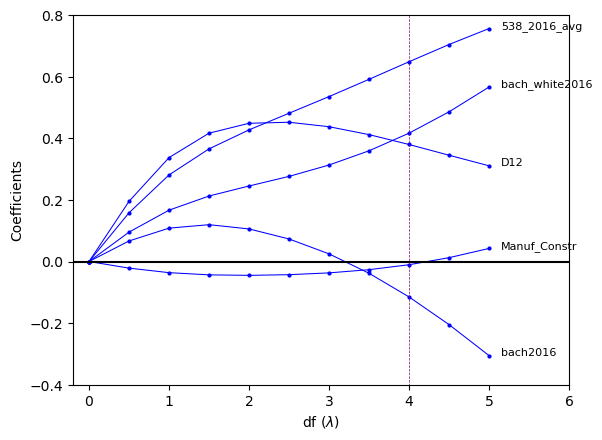

In [200]:
# Graphic.
const_model = np.zeros(5)
ridge_betas.insert(0, const_model)

dfs = np.arange(0, X.shape[1] + 0.5, 0.5)

plt.plot(dfs, ridge_betas, 'o-',markersize=2, c='blue', lw=0.75)

plt.ylabel('Coefficients')
plt.xlabel('df ($\lambda$)')

plt.hlines(y=0, xmin=-0.2, xmax=6, colors='black')
plt.plot([x_coord, x_coord],[-1,1], '--', color='purple', lw=0.5)

plt.xlim([-0.2, 6])
plt.ylim([-0.4, 0.8])

for x, y, s in zip(np.ones(5)*(5+0.15), ridge_betas[-1], X.columns):
    plt.text(x, y, s, color='0', fontsize=8)
plt.show()

The key to this analysis is that $df = 5$ when we're using OLS regression. So, the final point on these lines corresponds to the OLS estimates (without intercepts). When we move left on the curves, we see how the ridge regression alters these estimates.

First, the 538_2016_avg has been shrunk. Also, note that the bach_white2016 estimate has been reduced. The D12 estimate has increased slightly. Meanwhile, the manuf_constr coefficient has shrunk. And the bach2016 coefficient has increased.

In [201]:
# Coefficients from final model.
ridge_coefs = pd.DataFrame({
    'Variable': X.columns, 'OLS_est': model_OLS.df['Coefficient'][1:], 'Ridge_est': ridge_betas[-3]
})
ridge_coefs['diff'] = ridge_coefs['Ridge_est'] - ridge_coefs['OLS_est']
ridge_coefs

,Variable,OLS_est,Ridge_est,diff
1,D12,0.3108,0.379960,0.069160
2,bach2016,-0.3054,-0.114896,0.190504
3,bach_white2016,0.5665,0.416738,-0.149762
4,538_2016_avg,0.7564,0.648627,-0.107773
5,Manuf_Constr,0.0425,-0.010406,-0.052906


To conclude, the ridge regression has altered some of our estimates. Variables that have increased in their estimates are the 2012 election (indicating the past election's importance) and the general college education variable. We would expect this to be the case since the Democratic coalition should have more college-educated voters.

The coefficients that have shrunk correspond to the state's levels of college-educated whites, the 538 polling variable, and manufacturing and construction workers. Ignoring manufacturing and construction workers, the polls seem less critical than at face value. Additionally, we have lowered the estimate of the impact of white college-educated voters. Despite this, we are still close to our OLS estimates and nearly within one standard error of the previous estimate. 

We can conclude from this that the impact of college education on white voters is a strong determinant in the Democratic vote share in the 2016 presidential election. Holding all else equal, increasing college attainment among white voters by a percent would yield an increase of $0.004$ in the Democratic vote share for a typical state.